# モデルの構築と訓練

In [3]:
# パス追加処理
# commonフォルダにあるスクリプトのインポート
from pathlib import Path
import sys

sys.path.append(str(Path().resolve().parent))

In [4]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# パラメータ用意
from collections import namedtuple

Param = namedtuple("Param", [
    "n_epoch","batch_size", "lr", "verbose",        # 学習パラメータ
    "load_data_path",                               # データ保存パス
    "save_model_path",                              # モデル保存パス
])

param = Param(
    30,                                             # n_epoch
    64,                                             # batch_size
    0.001,                                          # lr
    1,                                              # verbose
    "./.data",                                      # load_data_path
    "./model_param/latest_train_model.pth",         # save_model_path
)

## 訓練データ用意

In [6]:
from torchvision import transforms

affine = transforms.RandomAffine(
    (-30, 30),              # 回転
    scale=(0.8, 1.2),       # 拡大縮小
    translate=(0.5, 0.5)    # 並行移動
)
flip = transforms.RandomHorizontalFlip(p=0.5)       # 左右反転
invert = transforms.RandomInvert(p=0.5)             # 色反転
to_tensor = transforms.ToTensor()                   # テンソル変換
normalize = transforms.Normalize((0.0), (1.0))      # 正規化(平均:0, 標準偏差:1)
erase = transforms.RandomErasing(p=0.5)             # マスキング

In [7]:
# transform用意
transform_train = transforms.Compose([affine, flip, invert, to_tensor, normalize, erase])
transform_test = transforms.Compose([to_tensor, normalize])

In [8]:
# データ用意
from torchvision.datasets import FashionMNIST

fashion_train = FashionMNIST(param.load_data_path, train=True, download=True, transform=transform_train)
fashion_test = FashionMNIST(param.load_data_path, train=False, download=True, transform=transform_test)

In [9]:
# DataLoader用意
from torch.utils.data import DataLoader

train_loader = DataLoader(fashion_train, batch_size=param.batch_size, shuffle=True)
test_loader = DataLoader(fashion_test, batch_size=param.batch_size, shuffle=False)

## モデル構築

In [10]:
from common.network import Net

net = Net()
net = net.to(device)

In [11]:
net

Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

## 学習

In [12]:
from torch import nn
from torch import optim

# 損失関数、最適化アルゴリズム
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=param.lr)

# 損失のログ
record_loss_train = []
record_loss_test = []

# 学習
for epoch in range(param.n_epoch):
    # --------------------------------------------------
    # 学習処理
    # --------------------------------------------------
    net.train()         # 訓練モード
    loss_train = 0.0

    for (x, t) in train_loader:
        x, t = x.to(device), t.to(device)       # GPU環境であれば、GPUにデータを送る
        y = net(x)
        loss = loss_func(y, t)
        loss_train += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_train /= len(train_loader)
    record_loss_train.append(loss_train)

    # --------------------------------------------------
    # 評価処理
    # --------------------------------------------------
    net.eval()          # 評価モード
    loss_test = 0.0

    for (x, t) in test_loader:
        x, t = x.to(device), t.to(device)       # GPU環境であれば、GPUにデータを送る
        y = net(x)
        loss = loss_func(y, t)
        loss_test += loss.item()

    loss_test /= len(test_loader)
    record_loss_test.append(loss_test)

    # 進捗表示
    if epoch % param.verbose == 0:
        print(f"Epoch: {epoch + 1}, Loss(Train): {loss_train}, Loss(Test): {loss_test}")

Epoch: 1, Loss(Train): 1.8722395720258196, Loss(Test): 1.2947222191816683
Epoch: 2, Loss(Train): 1.5779553635288148, Loss(Test): 1.1357071802114984
Epoch: 3, Loss(Train): 1.484864298468714, Loss(Test): 1.0150757993862127
Epoch: 4, Loss(Train): 1.4070750003430381, Loss(Test): 0.9526954502057118
Epoch: 5, Loss(Train): 1.3599784316411658, Loss(Test): 1.0382259848770823
Epoch: 6, Loss(Train): 1.3191562232051068, Loss(Test): 0.7999734248325323
Epoch: 7, Loss(Train): 1.2873496310924417, Loss(Test): 0.7643115402786596
Epoch: 8, Loss(Train): 1.2504562340311405, Loss(Test): 0.769139297069258
Epoch: 9, Loss(Train): 1.2234913917111436, Loss(Test): 0.7712670560855015
Epoch: 10, Loss(Train): 1.200419548033143, Loss(Test): 0.7298377957313683
Epoch: 11, Loss(Train): 1.1841762461133603, Loss(Test): 0.6979786030426147
Epoch: 12, Loss(Train): 1.170539353193759, Loss(Test): 0.7082459448249476
Epoch: 13, Loss(Train): 1.1474881270038548, Loss(Test): 0.7081948809183327
Epoch: 14, Loss(Train): 1.133462659077

## 評価

### 誤差の推移

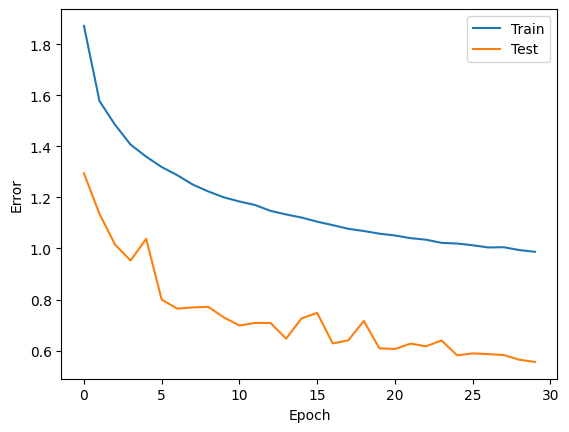

In [13]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show()

### 正解率

In [14]:
correct = 0
total = 0

net.eval()
for (x, t) in test_loader:
    x, t = x.to(device), t.to(device)
    y = net(x)
    correct += (y.argmax(1) == t).sum().item()
    total += len(x)

print(f"accuracy: {correct / total}")

accuracy: 0.804


## モデル保存

In [15]:
# state_dict確認
for k in net.state_dict():
    print(f"{k}: {net.state_dict()[k].size()}")

conv1.weight: torch.Size([8, 1, 3, 3])
conv1.bias: torch.Size([8])
conv2.weight: torch.Size([16, 8, 3, 3])
conv2.bias: torch.Size([16])
bn1.weight: torch.Size([16])
bn1.bias: torch.Size([16])
bn1.running_mean: torch.Size([16])
bn1.running_var: torch.Size([16])
bn1.num_batches_tracked: torch.Size([])
conv3.weight: torch.Size([32, 16, 3, 3])
conv3.bias: torch.Size([32])
conv4.weight: torch.Size([64, 32, 3, 3])
conv4.bias: torch.Size([64])
bn2.weight: torch.Size([64])
bn2.bias: torch.Size([64])
bn2.running_mean: torch.Size([64])
bn2.running_var: torch.Size([64])
bn2.num_batches_tracked: torch.Size([])
fc1.weight: torch.Size([256, 1024])
fc1.bias: torch.Size([256])
fc2.weight: torch.Size([10, 256])
fc2.bias: torch.Size([10])


In [16]:
# 保存
import os

os.makedirs(os.path.dirname(param.save_model_path), exist_ok=True)

torch.save(net.state_dict(), param.save_model_path)